In [1]:
using CairoMakie
using NCDatasets
using Oceananigans
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [2]:
simulation = HorizontalConvectionSimulation(h₀_frac=0.6, output_writer=false, architecture=CPU())

Simulation of NonhydrostaticModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 6.250 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 3.333 minutes
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 6 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   ├── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
│   ├── wizard => Callback of TimeStepWizard(cfl=0.5, max_Δt=Inf, min_Δt=0.0) on IterationInterval(50)
│   └── progress => Callback of (::TopographicHorizontalConvection.var"#progress#7") on IterationInterval(10)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [3]:
grid = simulation.model.grid.underlying_grid

2048×64×256 RectilinearGrid{Float64, Bounded, Periodic, Bounded} on CPU with 4×4×4 halo
├── Bounded  x ∈ [-4.0, 4.0]     regularly spaced with Δx=0.00390625
├── Periodic y ∈ [-0.125, 0.125) regularly spaced with Δy=0.00390625
└── Bounded  z ∈ [-1.0, 0.0]     regularly spaced with Δz=0.00390625

In [4]:
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"));

In [5]:
b = ds["b"][4+1:end-4, 4+1:end-4, 4+1:end-4, 15]; # get rid of halos
b_flat = vcat(b...);

In [6]:
z = ds["zC"][4+1:end-4]
z_3d = repeat(reshape(z, 1,1,grid.Nz), grid.Nx, grid.Ny, 1)
z_flat = vcat(z_3d...);

In [7]:
wet = b.!=0. # This does not work for the initial timestep because our initial condition is that b==0 everywhere!
wet_flat = vcat(wet...);
b_flat[.!wet_flat] .= NaN;

In [8]:
sort_idx = sortperm(b_flat);
b_sorted, z_sorted = b_flat[sort_idx], z_flat[sort_idx];

In [9]:
Δx = xspacings(grid, Center(), Center(), Center())
Δy = xspacings(grid, Center(), Center(), Center())
Δz = xspacings(grid, Center(), Center(), Center())
ΔA = Δx*Δy
ΔV = ΔA*Δz;

In [10]:
A_wet = dropdims(sum(wet*ΔA, dims=(1,2)), dims=(1,2));

In [11]:
using Interpolations

In [12]:
A_interpolation = linear_interpolation(z, A_wet, extrapolation_bc=Line());

In [13]:
zstar_flat = zeros(size(b_sorted)) .+ grid.zᵃᵃᶠ[1]
for k in 2:length(b_sorted)
    A = A_interpolation(zstar_flat[k-1])
    if !isnan(b_sorted[k])
        zstar_flat[k] = zstar_flat[k-1] + ΔV/A
    else
        zstar_flat[k] = NaN
    end
end

In [14]:
unsort_idx = sortperm(sort_idx);
zstar = reshape(zstar_flat[unsort_idx], size(b));

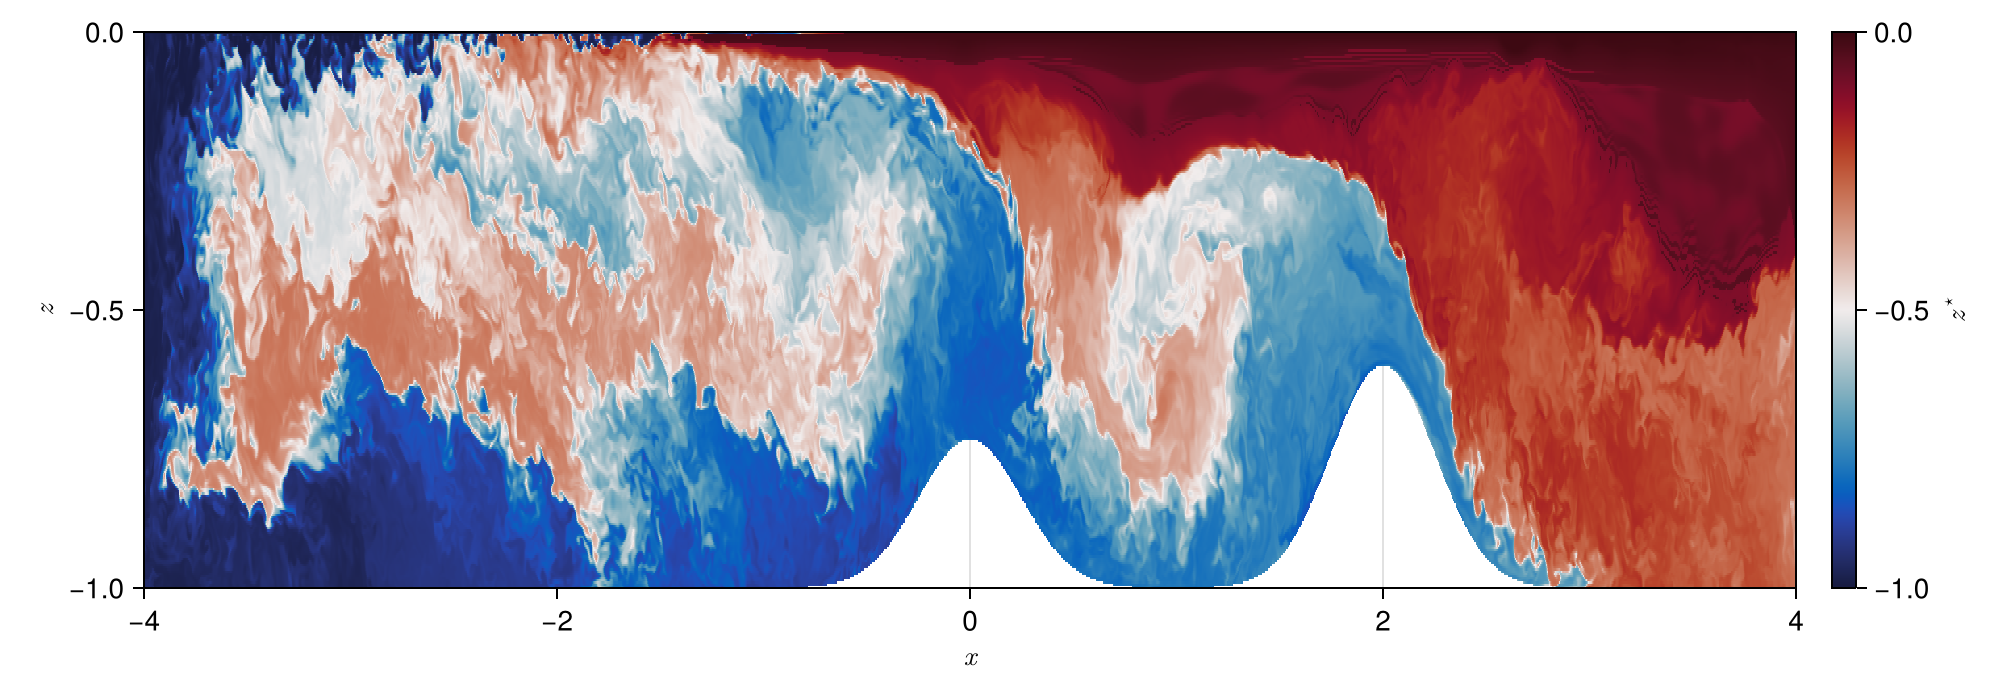

In [16]:
f = Figure(size=(1000, 350))
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], zstar[:,grid.Ny÷2,:], colorrange = (-1, 0), colormap = :balance)
Colorbar(f[1,2], hm, label=L"$z^{\star}$");
f